# Loading data

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

cols = ['Cust_Id','Rating','Date']
# read in the data from the 4 txt files into 4 separate panda dataframes
df = pd.read_csv('netflix-prize-data/combined_data_1.txt',header=None,names=cols)
# df2 = pd.read_csv('netflix-prize-data/combined_data_2.txt',header=None,names=cols)
# df3 = pd.read_csv('netflix-prize-data/combined_data_3.txt',header=None,names=cols)
# df4 = pd.read_csv('netflix-prize-data/combined_data_4.txt',header=None,names=cols)

In [21]:
# merge the 4 dataframes into one
# df = pd.concat([df1, df2, df3, df4])

df.index = np.arange(0,len(df))
print('Full dataset shape: {}'.format(df.shape))
print('-Dataset examples-')
print(df.iloc[::5000000, :])

Full dataset shape: (24058263, 3)
-Dataset examples-
          Cust_Id  Rating        Date
0              1:     NaN         NaN
5000000   2560324     4.0  2005-12-06
10000000  2271935     2.0  2005-04-11
15000000  1921803     2.0  2005-01-31
20000000  1933327     3.0  2004-11-10


# Viewing data

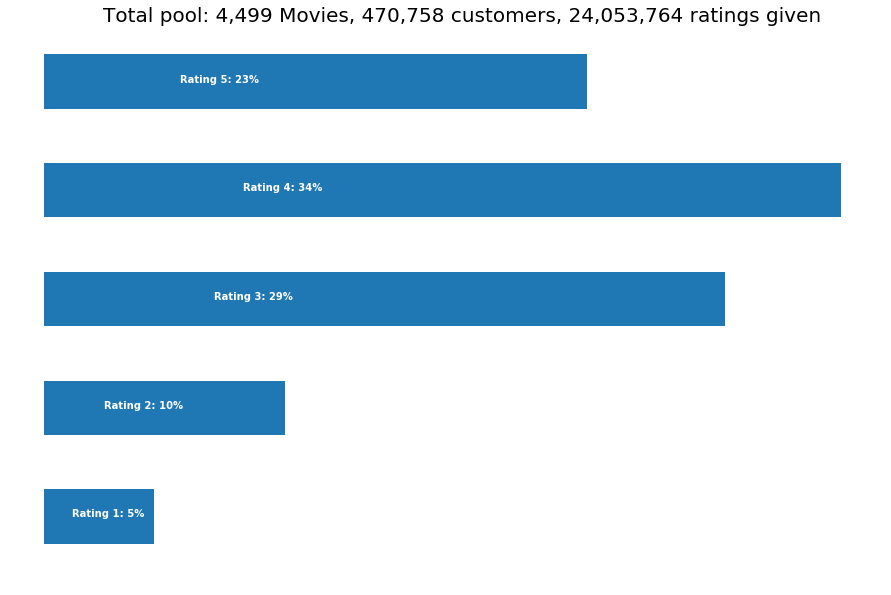

In [22]:
p = df.groupby('Rating')['Rating'].agg(['count'])

# get movie count
movie_count = df.isnull().sum()[1]

# get customer count
cust_count = df['Cust_Id'].nunique() - movie_count

# get rating count
rating_count = df['Cust_Id'].count() - movie_count

ax = p.plot(kind = 'barh', legend = False, figsize = (15,10))
plt.title('Total pool: {:,} Movies, {:,} customers, {:,} ratings given'.format(movie_count, cust_count, rating_count), fontsize=20)
plt.axis('off')

for i in range(1,6):
    ax.text(p.iloc[i-1][0]/4, i-1, 'Rating {}: {:.0f}%'.format(i, p.iloc[i-1][0]*100 / p.sum()[0]), color = 'white', weight = 'bold')


# Cleaning data

In [23]:
df_nan = pd.DataFrame(pd.isnull(df.Rating))
df_nan = df_nan[df_nan['Rating'] == True]
df_nan = df_nan.reset_index()

movie_np = []
movie_id = 1

for i,j in zip(df_nan['index'][1:],df_nan['index'][:-1]):
    temp = np.full((1,i-j-1), movie_id)
    movie_np = np.append(movie_np, temp)
    movie_id += 1

# Account for last record and corresponding length
last_record = np.full((1,len(df) - df_nan.iloc[-1, 0] - 1),movie_id)
movie_np = np.append(movie_np, last_record)

print('Movie numpy: {}'.format(movie_np))
print('Length: {}'.format(len(movie_np)))

Movie numpy: [1.000e+00 1.000e+00 1.000e+00 ... 4.499e+03 4.499e+03 4.499e+03]
Length: 24053764


In [24]:
# remove Movie ID rows with NaN ratings
df = df[pd.notnull(df['Rating'])]

df['Movie_Id'] = movie_np.astype(int)
df['Cust_Id'] = df['Cust_Id'].astype(int)
print('-Dataset examples-')
print(df.iloc[::5000000, :])

-Dataset examples-
          Cust_Id  Rating        Date  Movie_Id
1         1488844     3.0  2005-09-06         1
5000996    501954     2.0  2004-08-26       996
10001962   404654     5.0  2005-08-29      1962
15002876   886608     2.0  2005-09-19      2876
20003825  1193835     2.0  2003-08-13      3825


# Reducing Data 

In [25]:
f = ['count','mean']

# Drop movies that have too little reviews (too little ~ less that the 80% quantile)
df_movie_summary = df.groupby('Movie_Id')['Rating'].agg(f)
df_movie_summary.index = df_movie_summary.index.map(int)
movie_benchmark = round(df_movie_summary['count'].quantile(0.8),0)
drop_movie_list = df_movie_summary[df_movie_summary['count'] < movie_benchmark].index

print('Movie minimum times of review: {}'.format(movie_benchmark))

# Drop customers that give too little reviews (too little ~ less that the 80% quantile)
df_cust_summary = df.groupby('Cust_Id')['Rating'].agg(f)
df_cust_summary.index = df_cust_summary.index.map(int)
cust_benchmark = round(df_cust_summary['count'].quantile(0.8),0)
drop_cust_list = df_cust_summary[df_cust_summary['count'] < cust_benchmark].index

print('Customer minimum times of review: {}'.format(cust_benchmark))

Movie minimum times of review: 3884.0
Customer minimum times of review: 79.0


In [26]:
print('Original Shape: {}'.format(df.shape))
df = df[~df['Movie_Id'].isin(drop_movie_list)]
df = df[~df['Cust_Id'].isin(drop_cust_list)]
print('After Trim Shape: {}'.format(df.shape))
print('-Data Examples-')
print(df.iloc[::5000000, :])

Original Shape: (24053764, 4)
After Trim Shape: (13528427, 4)
-Data Examples-
          Cust_Id  Rating        Date  Movie_Id
5109       785314     1.0  2005-07-13         8
8889698    332300     3.0  2004-07-13      1770
17751978   629874     4.0  2005-11-22      3391


In [27]:
df_p = pd.pivot_table(df,values='Rating',index='Cust_Id',columns='Movie_Id')

print(df_p.shape)

(95325, 900)


# Mapping Movie ID to Movie titles


In [29]:
df_title = pd.read_csv('netflix-prize-data/movie_titles.csv', encoding = "ISO-8859-1", header = None, names = ['Movie_Id', 'Year', 'Name'])
df_title.set_index('Movie_Id', inplace = True)
print(df_title.head(10))

            Year                          Name
Movie_Id                                      
1         2003.0               Dinosaur Planet
2         2004.0    Isle of Man TT 2004 Review
3         1997.0                     Character
4         1994.0  Paula Abdul's Get Up & Dance
5         2004.0      The Rise and Fall of ECW
6         1997.0                          Sick
7         1992.0                         8 Man
8         2004.0    What the #$*! Do We Know!?
9         1991.0      Class of Nuke 'Em High 2
10        2001.0                       Fighter


In [36]:
df.head(10)

,Cust_Id,Rating,Date,Movie_Id
5109,785314,1.0,2005-07-13,8
5110,243963,3.0,2005-07-15,8
5112,1447783,4.0,2005-07-19,8
5116,1912665,1.0,2005-08-21,8
5119,1744889,1.0,2005-08-25,8
5122,2289614,3.0,2005-03-20,8
5125,2460625,3.0,2005-03-21,8
5127,2330282,4.0,2005-03-29,8
5128,2098867,4.0,2005-03-22,8
5129,1395430,2.0,2005-03-22,8


In [71]:
# pivot dataframe to show just customer-movie interactions (users as rows & movies as columns)
new_df = pd.pivot_table(df, values=['Rating'], index=['Cust_Id'],columns=['Movie_Id'])

# Change NaN values for rating to 0
new_df.fillna(0, inplace=True)

new_df.head(10)

Rating                                              ...             \
Movie_Id   8    17   18   26   28   30   33   44   46   52   ...  4454 4465   
Cust_Id                                                      ...              
6           0.0  0.0  0.0  0.0  0.0  3.0  0.0  0.0  0.0  0.0 ...   0.0  0.0   
7           5.0  0.0  0.0  0.0  4.0  5.0  0.0  0.0  0.0  0.0 ...   0.0  2.0   
79          0.0  0.0  0.0  0.0  0.0  3.0  0.0  0.0  0.0  0.0 ...   0.0  0.0   
97          0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0  0.0   
134         0.0  0.0  0.0  0.0  5.0  0.0  0.0  0.0  0.0  0.0 ...   0.0  0.0   
188         0.0  0.0  0.0  0.0  0.0  3.0  0.0  0.0  0.0  0.0 ...   0.0  0.0   
195         0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0  0.0   
199         0.0  0.0  0.0  0.0  0.0  5.0  0.0  0.0  0.0  0.0 ...   0.0  0.0   
201         0.0  0.0  0.0  0.0  4.0  5.0  0.0  0.0  0.0  0.0 ...   0.0  0.0   
265         0.0  0.0  0.0  0.0  3.0  5.0  0.0  0.0  0.0  0.0 ...   0.0  0.0   

                                                  
Movie_Id 4472 4474 4479 4488 4490 4492 4493 4496  
Cust_Id                                           
6         3.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
7         3.0  0.0  5.0  0.0  0.0  0.0  0.0  0.0  
79        4.0  0.0  0.0  0.0  4.0  0.0  0.0  0.0  
97        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
134       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
188       0.0  0.0  0.0  0.0  3.0  3.0  0.0  0.0  
195       4.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
199       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
201       2.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
265       4.0  0.0  0.0  4.0  0.0  0.0  0.0  0.0  

[10 rows x 900 columns]

# Recommendation using Matrix Factorization (SVD)

In [216]:
def recommend(full_df, user_ID, num_recommendations, k=10):
    """
    full_df: the full dataframe showing customer-movie interactions (users as rows & movies as columns)
    user_ID: id of the user we are making the recommendations to
    num_recommendations: number of recommendations to make
    k: number of latent factors to use     
    """
    full_df = new_df
    user_ID = 7
    num_recommendations = 10
    k =50
    # normalize each user by subtracting out ther average ratings of that user
    data_uncentered = full_df.as_matrix()
    user_ratings_mean = np.mean(data_uncentered, axis = 1)
    data = data_uncentered - user_ratings_mean.reshape(-1, 1)

    # do SVD on the data matrix with as many latent factors as requested
    U, sigma, Vt = svds(data, k )
    sigma = np.diag(sigma)
    all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) + user_ratings_mean.reshape(-1, 1)
    preds_df = pd.DataFrame(all_user_predicted_ratings, columns = full_df.columns, index=full_df.index)
    user_hist = full_df[full_df['Rating']!=0].loc[[user_ID]]
    recom = preds_df[full_df['Rating']==0].loc[[user_ID]]
    recom.columns = recom.columns.droplevel()
    recommendations = pd.pivot_table(recom, index=['Cust_Id'])
    user_hist = pd.pivot_table(user_rated, index=['Cust_Id'])
    user_hist = user_hist.T
    user_hist = user_hist[user_hist[user_ID]==5]
    recommendations = recommendations.T
    recommendations = recommendations.sort_values(by=[user_ID], ascending=False)[:num_recommendations]
    user_hist.index = user_hist.index.droplevel()
    user_hist = user_hist.join(df_title)['Name'].to_frame()
    recommendations = recommendations.join(df_title)['Name'].to_frame()
    return user_hist, recommendations

In [217]:
user_hist, recommendations = recommend(new_df, 6, 10, k=50)

C:\Users\Abel\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]


In [218]:
print('User {0} has already rated {1} movies.'.format(6, user_hist.shape[0]))
user_hist.head(20)

User 6 has already rated 78 movies.


,Name
Movie_Id,
8,What the #$*! Do We Know!?
30,Something's Gotta Give
83,Silkwood
175,Reservoir Dogs
257,Charlotte's Web
283,If These Walls Could Talk
285,The Devil's Own
313,Pay It Forward
357,House of Sand and Fog


In [219]:
print('Recommending the highest {0} predicted ratings movies not already rated.'.format(num_recommendations))
recommendations

Recommending the highest 10 predicted ratings movies not already rated.


,Name
Movie_Id,
1615,The American President
3079,The Lion King: Special Edition
197,Taking Lives
482,Frida
3148,The English Patient
1466,Midnight Cowboy
2594,Look Who's Talking
3017,Cocoon
1744,Beverly Hills Cop


## References:  
Instructions for Preprocessing the data were found [here](https://www.kaggle.com/laowingkin)  
Article on Matrix Factorization Techniques for Recommender Systems [here](https://datajobs.com/data-science-repo/Recommender-Systems-[Netflix].pdf)